In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [127]:
def step(action):
    # Pull arm and get reward from its gaussian distribution
    return np.random.normal(arm_mean[action], arm_dev[action])

def update_Q(action, reward, learning_rate):
    # Update Q action-value given (action, reward)
    global alpha

    if learning_rate == 'rescorla_wagner':
        n[action] += 1
        Q[action] += alpha * (reward - Q[action])
        
    if learning_rate == 'kalman':
        alpha = sigma_sq[action] / (sigma_sq[action] + tau_sq[action])
        sigma_sq[action] -= alpha * sigma_sq[action]
        n[action] += 1
        Q[action] += alpha * (reward - Q[action])

def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        
        if cum_prob > z:
            return i
    return len(probs) - 1

def get_action(mode):
    if mode == 'e_greedy':
        # Epsilon-greedy policy
        if np.random.random() < eps: # explore
            return np.random.randint(len(arm_mean))
        else: # exploit
            return np.random.choice(np.flatnonzero(Q == Q.max()))
    
    if mode == 'softmax':
        # Softmax policy
        z = sum([math.exp(q * beta) for q in Q])
        probs = [math.exp(q * beta) / z for q in Q]
        
        # Use categorical_draw to pick arm
        return categorical_draw(probs)
    
    if mode == 'hybrid':
        # Hybrid policy
        Vt = Q[0] - Q[1]
        RUt = np.sqrt(sigma_sq[0]) - np.sqrt(sigma_sq[1])
        TUt = np.sqrt(sigma_sq[0] + sigma_sq[1])
        prob1 = norm.cdf(hybrid_w[0]*Vt + hybrid_w[1]*RUt + hybrid_w[2]*(Vt/TUt), loc=0, scale=1)
        prob2 = 1 - prob1
        probs = [prob1, prob2]

        # Use categorical_draw to pick arm
        return categorical_draw(probs)

In [178]:
# Settings
prng = np.random.RandomState(123456789)
# arm_mean = [-1, 1] # mean for reward function of each arm
# arm_dev = np.ones(10)
# tau_sq = np.ones(10)
arm_dev = [4.0, 0] # standard deviation for reward function of each arm
tau_sq = [16, 0.00001] # variance of the risky and safe arms (note: safe arm has non-zero var. to avoid numerical issues)
N_experiments = 1000 # number of experiments to perform
N_steps = 500 # number of steps (episodes)
eps = 0.0 # probability of random exploration (fraction)
beta = 1.0 # hyperparameter that determines how much randomisation in arm selection for softmax policy
mode = 'hybrid' # 'e_greedy' / 'softmax' / 'hybrid'
learning_rate = 'kalman' # kalman / rescorla-wagner
# alpha = 1
hybrid_w = [1.15, 0.3, 0.6] # weights for the regressors of the hybrid model

R = np.zeros((N_steps,))  # reward history sum
A_tot = []
A_max_tot = np.zeros(N_steps) # array with number of times optimal arm has been chosen across all experiments
for i in range(N_experiments):
    A = np.zeros((N_steps, len(arm_dev)))  # action history sum
    arm_mean = prng.normal(0, 10, 2)
    actions, rewards = [], []
    n = np.zeros(len(arm_mean), dtype=np.int) # action counts n(a)
    Q = np.zeros(len(arm_mean), dtype=np.float) # value Q(a)
    sigma_sq = tau_sq
    for episode in range(N_steps):
        action = get_action(mode) # sample policy
        reward = step(action) # take step + get reward
        update_Q(action, reward, learning_rate) # update Q
        actions.append(action)
        rewards.append(reward)
    R += rewards
    for j, a in enumerate(actions):
        A[j][a] += 1
    A_tot.append(A)
    max_arm = np.where(arm_mean == np.max(arm_mean))
    A_max = A[:,max_arm[0]].T[0]
    A_max_tot = np.add(A_max_tot, A_max)

In [179]:
A_max_tot_multiple = [] # array for multiple beta
A_max_tot_multiple.append(A_max_tot)

R_tot = []
R_tot.append(R)

Total reward for hybrid : 2241.9526616498424


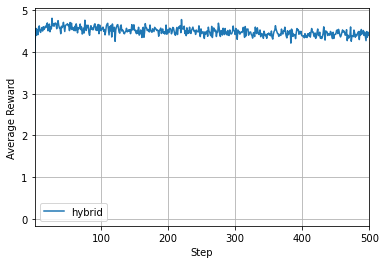

In [180]:
# Plot reward results
legend = ['hybrid', 'Thompson', 'UCB', 'softmax', 's2']
for i, j in enumerate(R_tot):
    data = j / N_experiments
    print('Total reward for', legend[i], ':', sum(data))
    plt.plot(data, label=legend[i])
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.grid()
plt.xlim([1, N_steps])
plt.legend()
plt.show()

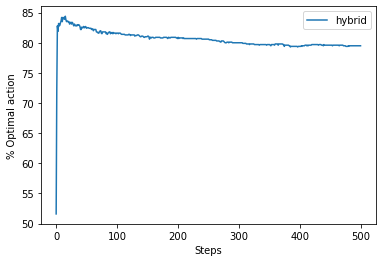

In [181]:
legend = ['hybrid', 'Thompson', 'UCB', 'softmax', 'sc2']
# legend = ['']
plt_steps = np.arange(0, N_steps)
for i, j in enumerate(A_max_tot_multiple):
    data = 100 * j / N_experiments
    plt.plot(plt_steps, data, label=legend[i])
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.legend()
plt.show()

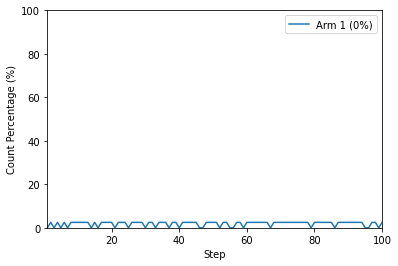

In [38]:
data = 100 * A[:, 0] / N_experiments
window = 2
average_data = []
steps = list(np.array(range(len(A)))+1)
for ind in range(len(data) - window + 1):
    average_data.append(np.mean(data[ind:ind+window]))
plt_steps = np.arange(window - 1, len(steps))
plt.plot(steps, data, label="Arm {} ({:.0f}%)".format(1, arm_mean[0]))
plt.xlabel("Step")
plt.ylabel("Count Percentage (%)")
plt.xlim([1, N_steps])
plt.ylim([0, 100])
leg = plt.legend(loc='upper left', shadow=True)
plt.legend()
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
plt.show()

In [7]:
prng = np.random.RandomState(123456789)
a = prng.normal(0, 1, 1)
b = prng.normal(0, 1, 1)
c = prng.normal(0, 1, 1)
c2 = prng.normal(0, 1, 1)
d = prng.normal(0, 1, 1)
print(a, b, c, d)

[2.212902] [2.1283978] [1.8417114] [0.85896368]


In [8]:
prng = np.random.RandomState(123456789)
a = prng.normal(0, 1, 2)
b = prng.normal(0, 1, 1)
c = prng.normal(0, 1, 1)
d = prng.normal(0, 1, 1)
print(a, b, c, d)

[2.212902  2.1283978] [1.8417114] [0.08238248] [0.85896368]


In [26]:
a = [1, 2, 3, 4, 5, 10, 7, 8, 9, 0]
a_max = np.max(a)
max_ind = np.where(a == a_max)
print(max_ind[0])
a[int(max_ind[0])]

[5]


10

In [35]:
a = []
b = [1,2,3]
c = [3,4,5]
a.append(b)
a.append(c)
print(a)

[[1, 2, 3], [3, 4, 5]]
